# Data Pre-Processing Notebook
This notebook contains the data processing for the project's F1 Kaggle datasets.

In [1]:
#Import general pytohn packages
import pandas as pd
import numpy as np

#Modelling packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm

from scipy.stats import jarque_bera, normaltest

#Import Python packages prepared for this project
from workflowpackages.data import get_kaggle_f1_data
#-------------------------
#For complete code regarding the package see 'workflowpackages' .py files
#You can also type ? and ?? after the imported function to see documentation and full source code in-line
#-------------------------

In [2]:
get_kaggle_f1_data(force_download=False)

No missing datasets. The following datasets are available:
- circuits.csv
- constructors.csv
- lap_times.csv
- races.csv
- sprint_results.csv
- constructor_results.csv
- driver_standings.csv
- pit_stops.csv
- results.csv
- status.csv
- constructor_standings.csv
- drivers.csv
- qualifying.csv
- seasons.csv


In [3]:
#READ DATA
#Read the dataframes from the source and label them
df_results = pd.read_csv('datasets/f1/results.csv')
df_races = pd.read_csv('datasets/f1/races.csv')
df_drivers = pd.read_csv('datasets/f1/drivers.csv')
#--------------------------------------------------

#SELECT COLUMNS
#Select columns to keep for modelling in the dataframes
#Results data
results_cols = [
    'resultId', #Unique id for a race result per driver
    'raceId',
    'driverId',
    'grid',
    'position', #Numeric, null if position text is R, D, or W - meaning the car was retired, disqualified, or withdrawn
    'positionText' #String, same as position, instead of null, indicates R, D, or W
]
#Races data
races_cols = [
    'raceId',
    'year',
    'date'
]
#Drviers data
drivers_cols = [
    'driverId',
    'dob' #Driver code based on driver last name
]
#---------------------------------------------------

#FILTER DATA
#Filter the dataframes by selected columns
df_results = df_results[results_cols]
df_races = df_races[races_cols]
df_drivers = df_drivers[drivers_cols]
#---------------------------------------------------

#JOIN THE DATA
#Join the races data to results dataframe
df_model = df_results.merge(
    df_races,
    how = 'inner',
    on = 'raceId',
)
#Join the drivers data to results dataframe
df_model = df_model.merge(
    df_drivers,
    how = 'inner',
    on = 'driverId',
)
#---------------------------------------------------

In [4]:
#Filter races to analyze (limit historical period)
mask = (df_model['year'] >= 2000) & (df_model['year'] != 2024)
df_model = df_model[mask]

In [5]:
#---------------------------------------------------
#FEATURE ENGINEERING
#---------------------------------------------------

#---------------------------------------------------
#DICOTOMIC FEATURES : CREATE DUMMY VARIABLES
#---------------------------------------------------

#Get dummies for Finished Race
dummies_finished = pd.get_dummies(
    #Modify positionText column to indicate "finished_race" if the car finished the race, otherwise "out"
    df_model['positionText'].apply(lambda x: 'finished_race' if str.isnumeric(x) else 'Out'),
    prefix = 'Car'
).drop(
    ['Car_finished_race'],
    axis = 1
)
#Join dummies to model dataset
df_model = df_model.merge(
    dummies_finished,
    how = 'inner',
    left_index = True,
    right_index = True
).drop(
    ['positionText'],
    axis = 1
)
#---------------------------------------------------

#Get dummies for Driver id
dummies_drivers = pd.get_dummies(
    df_model['driverId'],
    prefix = 'Driver'
)
#Join dummies to model dataset
df_model = df_model.merge(
    dummies_drivers,
    how = 'inner',
    left_index = True,
    right_index = True
)
#---------------------------------------------------

#Get dummies for season
dummies_season = pd.get_dummies(
    df_model['year'],
    prefix = 'Season'
)
#Join dummies to model dataset
df_model = df_model.merge(
    dummies_season,
    how = 'inner',
    left_index = True,
    right_index = True
)
#---------------------------------------------------

#---------------------------------------------------
#DRIVER FEATURES
#---------------------------------------------------

#DRIVERS AGE
#Change to datetime
df_model['dob'] = pd.to_datetime(df_model['dob'])
df_model['date'] = pd.to_datetime(df_model['date'])

#Calculate the age in years at the time of the race
df_model['DriverAge'] = (df_model['date'] - df_model['dob']) / pd.Timedelta(days=365.25)
#---------------------------------------------------

#DRIVER YEARS OF F1 EXPERIENCE
#Calculate the min date (race date) by driver in the dataframe and join
df_model = df_model.merge(
    pd.pivot_table(
        df_model,
        index = 'driverId',
        values = 'date',
        aggfunc = 'min'
    ).reset_index().rename(columns = {'date':'DriverVintage'}),
    how = 'inner',
    on = 'driverId'
)
#Calculate the years of experience at the time of the race
df_model['DriverExpYears'] = (df_model['date'] - df_model['DriverVintage']) / pd.Timedelta(days=365.25)
#---------------------------------------------------

#---------------------------------------------------
#RESULTS FEATURES
#---------------------------------------------------

#OTHER DRIVERS RESULTS IN THE GRID
#Position, cero if null
df_model['position'] = df_model['position'].apply(lambda x : 0 if x == '\\N' else x).astype('float')

#Calculate a column per driver per race with their grid position
race_driver_grid = pd.pivot_table(
    df_model,
    index = 'raceId',
    columns = 'driverId',
    values = 'position',
    aggfunc = 'max'
).fillna(0)

#Get column names, append Driver as prefix and Grid as suffix to column names
race_driver_gid_cols = {}
for x in race_driver_grid.columns:
    race_driver_gid_cols[x] = 'Driver' + str(x) + '_Grid'
    
#Rename columns
race_driver_grid = race_driver_grid.rename(columns=race_driver_gid_cols)

#Merge with original dataframe
df_model = df_model.merge(
    race_driver_grid,
    how = 'inner',
    on = 'raceId'
)
#---------------------------------------------------

#---------------------------------------------------
#CLEAN REMMAINING DATA COLUMNS
#---------------------------------------------------
#Clean nulls and change datatypes

#Change to float
df_model['grid'] = df_model['grid'].astype('float')
#---------------------------------------------------

In [6]:
#MODELLING

#Feature Selection
#Define model dataset

#List continious columns, useful for standard scaler later in the code
model_cont_cols = [
    'grid',
    'DriverAge',
    'DriverExpYears'
]

#Append continious variables to column list
model_cols = []
for x in model_cont_cols:
    model_cols.append(x)

#Append Finished Dummies, not in previous list excluding last Dummy Variable to avoid perfect multicolinearity
if len(dummies_finished.columns[:len(dummies_finished.columns)]) == 1:
    model_cols.append(dummies_finished.columns[0])
else:
    for x in dummies_finished.columns[:len(dummies_finished.columns) -1]:
        model_cols.append(x)
    
#Append Driver Dummies, not in previous list excluding last Dummy Variable to avoid perfect multicolinearity
for x in dummies_drivers.columns[:len(dummies_drivers.columns) -1]:
    model_cols.append(x)
    
#Append Season Dummies, not in previous list excluding last Dummy Variable to avoid perfect multicolinearity
for x in dummies_season.columns[:len(dummies_season.columns) -1]:
    model_cols.append(x)
    
#Append Driver Grid variables, not in previous list, excluding to avoid scaling these features
for x in race_driver_gid_cols.values():
    model_cols.append(x)
#---------------------------------------------------

#Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df_model[model_cols].astype(float), 
    df_model['position'].astype(float),
    test_size = 0.3,
    random_state = 37 #Because 37 is a fantabulous number
)
#----------------------------------------------------

In [7]:

#Check Dataset info
X_train.info()
#----------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6720 entries, 1769 to 1935
Columns: 272 entries, grid to Driver859_Grid
dtypes: float64(272)
memory usage: 14.0 MB


In [8]:

#Preview model dataset
X_train.head()
#----------------------------------------------------

,grid,DriverAge,DriverExpYears,Car_Out,Driver_1,Driver_2,Driver_3,Driver_4,Driver_5,Driver_6,...,Driver850_Grid,Driver851_Grid,Driver852_Grid,Driver853_Grid,Driver854_Grid,Driver855_Grid,Driver856_Grid,Driver857_Grid,Driver858_Grid,Driver859_Grid
1769,16.0,21.336071,1.993155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
906,6.0,27.728953,2.318960,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1725,11.0,26.795346,1.284052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7031,17.0,30.699521,5.998631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5578,20.0,25.248460,0.229979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Apply Standard Scaler

# Create a transformer for continuous columns
ct = ColumnTransformer([
    ('scaler', StandardScaler(), model_cont_cols)
], remainder='passthrough')  # 'passthrough' leaves other columns (e.g., dummies) unchanged


#Instantiate scaler and fit transform
ct.fit_transform(X_train)

#Transform
Xs_train = ct.transform(X_train)
Xs_test = ct.transform(X_test)
#----------------------------------------------------

#Create polynomial features
poly = PolynomialFeatures(include_bias=False)
Xs_train_poly = poly.fit_transform(Xs_train)
Xs_test_poly = poly.transform(Xs_test)
#----------------------------------------------------

#Check Shape
Xs_train_poly.shape
#----------------------------------------------------

(6720, 37400)

In [10]:

#Do a simple Linear regression

#Uncomment/Comment the next lines of code to add a constant. 
#The model appears to perform better without constant.
X = sm.add_constant(Xs_train) 
#X = X_train 

slm = sm.OLS(y_train,X).fit()
slm_predictions = slm.predict(X)

print_model = slm.summary()
print(print_model)
#----------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:               position   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     58.35
Date:                Sat, 13 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:27:41   Log-Likelihood:                -17257.
No. Observations:                6720   AIC:                         3.505e+04
Df Residuals:                    6450   BIC:                         3.689e+04
Df Model:                         269                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7851      1.708      3.973      0.0

The mean of the residuals is:  -1.5546294410536836e-14
This is their JB test result --> 'statistic' : 291.57219523230117 'p-value' : 4.851793039377536e-64
This is their Normaltest result --> 'statistic' : 249.82875906057427 'p-value' : 5.628261399280192e-55


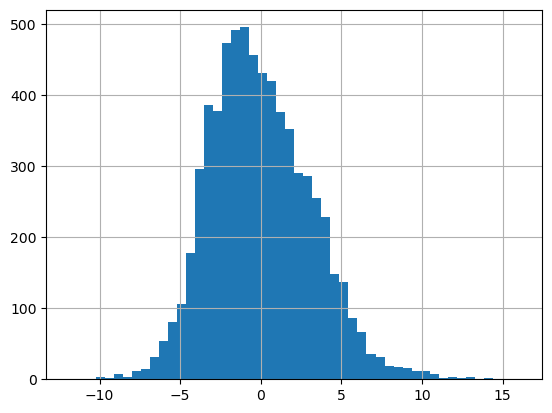

In [11]:

#Evaluate OLS normality assumptions
#Calculate residuals

slm_residuals = y_train - slm_predictions

#Check model normality
jb = jarque_bera(slm_residuals)
nt = normaltest(slm_residuals)

print('The mean of the residuals is: ',np.mean(slm_residuals))
print('This is their JB test result -->','\'statistic\' :', jb[0],'\'p-value\' :',jb[1])
print('This is their Normaltest result -->','\'statistic\' :', nt[0],'\'p-value\' :',nt[1])

slm_residuals.hist(bins=50);
#----------------------------------------------------

The model suffices two fundamental assumptions in the linear model:
1. The mean of $e$ (the error term) is cero, and
2. There is no multicorrelation of the error terms (the Durbin Watson test in 2)

In [12]:
#Improve regression with Ridge Regularization, Standarizing Data, and Polynomial Features
#Using Grid Search

#Instantiate Pipeline
pipeline = Pipeline([
    ('poly',PolynomialFeatures()),
    ('model',Ridge())
])

#Define parameters
params = {
    'poly__degree':[2,3],
    'poly__interaction_only':[True,False],
    'model__alpha': [1,10], #list(np.arange(5, 10, 1)),
    #'model__fit_intercept':[True,False]
}

#Instantiate Grid Search
gs = GridSearchCV(pipeline, params, cv=5)
gs.fit(Xs_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': [1, 10], 'poly__degree': [2]})

In [13]:
#Check best score
gs.best_score_

0.9515156762530566

In [14]:
#Check
gs.best_params_

{'model__alpha': 1, 'poly__degree': 2}

In [15]:
#Score in Train
gs.score(Xs_train,y_train)

0.9999936740177314

In [16]:
#Score in Test
gs.score(Xs_test,y_test)

0.9705038838389053

In [20]:

#Visualize position and predictions in a dataframe

#Rename predictions series and join series into dataframe
slm_ridge_predictions = pd.Series(gs.predict(Xs_train))
slm_ridge_predictions.name = 'predictions'            #Name series
slm_ridge_predictions.index = y_train.index           #Re-index
df_slm_ridge_results = y_train.to_frame().join(slm_ridge_predictions)

#Round results
df_slm_ridge_results['predictions'] = df_slm_ridge_results['predictions'].round().apply(lambda x : 0 if x <= 0 else x)

#Preview results for training set
df_slm_ridge_results.head()
#----------------------------------------------------

,position,predictions
1769,12.0,12.0
906,8.0,8.0
1725,15.0,15.0
7031,14.0,14.0
5578,16.0,16.0


In [18]:
#NOTE - move to package!
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
def classification_results(y_true, y_pred, method = 'micro'):

    # Compute classification statistics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=method)  
    recall = recall_score(y_true, y_pred, average=method)        
    f1 = f1_score(y_true, y_pred, average=method)                

    # Print the classification statistics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")


In [19]:
classification_results(df_slm_ridge_results['position'],df_slm_ridge_results['predictions'])

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [21]:
#Now for Testing Set

#Rename predictions series and join series into dataframe
slm_ridge_predictions = pd.Series(gs.predict(Xs_test))
slm_ridge_predictions.name = 'predictions'            #Name series
slm_ridge_predictions.index = y_test.index           #Re-index
df_slm_ridge_results = y_test.to_frame().join(slm_ridge_predictions)

#Round results
df_slm_ridge_results['predictions'] = df_slm_ridge_results['predictions'].round().apply(lambda x : 0 if x <= 0 else x)

#Preview results for training set
df_slm_ridge_results.head()
#----------------------------------------------------

,position,predictions
7660,9.0,9.0
1074,1.0,1.0
7121,11.0,8.0
6807,1.0,1.0
3784,13.0,13.0


In [22]:
classification_results(df_slm_ridge_results['position'],df_slm_ridge_results['predictions'])

Accuracy: 0.878125
Precision: 0.878125
Recall: 0.878125
F1 Score: 0.878125


In [26]:
# Compute the confusion matrix
cm = confusion_matrix(df_slm_ridge_results['position'],df_slm_ridge_results['predictions'])
print("Confusion Matrix:")
pd.DataFrame(cm)

Confusion Matrix:


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,556,37,16,9,14,5,1,0,2,1,...,1,0,0,0,0,0,0,0,0,0
1,1,125,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,122,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,119,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,120,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,125,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,2,130,5,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,2,4,126,3,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,2,3,128,4,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,3,7,131,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

#Visualize position and predictions in a dataframe

#Rename predictions series and join series into dataframe
slm_predictions.name = 'predictions'
df_slm_results = y_train.to_frame().join(slm_predictions)

#Round results
df_slm_results['predictions'] = df_slm_results['predictions'].round().apply(lambda x : 0 if x <= 0 else x)

#Preview results
df_slm_results.head()
#----------------------------------------------------

In [ ]:
classification_results(df_slm_results['position'],df_slm_results['predictions'])